Railway Knowledge System with rinna
===

Ren Nakagawa

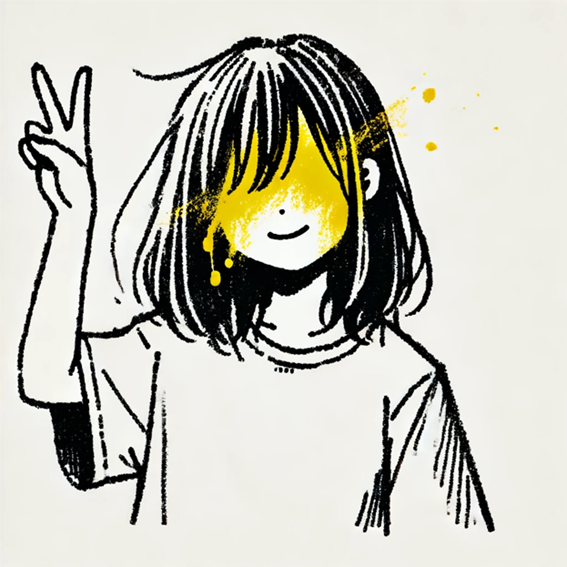

made by DALL-E 3

## Set up environment

In [1]:
!git clone https://github.com/rakawanegan/pbl-railway-knowledge-system
%cd pbl-railway-knowledge-system
%pip install transformers faiss-gpu fugashi ipadic >> install.txt

fatal: destination path 'pbl-railway-knowledge-system' already exists and is not an empty directory.
/content/pbl-railway-knowledge-system


## Import modules

In [2]:
from glob import glob
import markdown
from bs4 import BeautifulSoup
import torch
import faiss
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2LMHeadModel

## Set up dataset

In [3]:
!rm data.md
for file in sorted(glob('data/*.md')):
    print(file)
    !cat {file} >> data.md
    !echo "" >> data.md

data/01.md
data/02.md
data/04.md
data/05.md
data/09.md


## Load dataset

In [4]:
def load_markdown_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

markdown_text = load_markdown_file('data.md')
# print(markdown_text)

## RAG(retrieval augmented generation)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese")
model = AutoModel.from_pretrained("cl-tohoku/bert-base-japanese")

def embed_text(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings.numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# https://huggingface.co/tohoku-nlp/bert-base-japanese
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [7]:
# sentences = plain_text.split('\n')
sentences = markdown_text.split('\n')
embeddings = embed_text(sentences)
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

In [8]:
query = "新幹線の騒音防止に関する基準は？"
query_embedding = embed_text([query])

k = 2 # number of context
distances, indices = index.search(query_embedding, k)

context = " ".join([sentences[i] for i in indices[0] if i < len(sentences)])
prompt = f"Context: {context}\nQ: {query}\nA:"
print(prompt)

Context: 新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。
Q: 新幹線の騒音防止に関する基準は？
A:


In [9]:
del tokenizer, model

## Inference

In [10]:
tokenizer = AutoTokenizer.from_pretrained("rinna/japanese-gpt2-medium")
model = GPT2LMHeadModel.from_pretrained("rinna/japanese-gpt2-medium")

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [11]:
# https://huggingface.co/rinna/japanese-gpt2-medium
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(32000, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=32000, bias=False)
)


In [12]:
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
outputs = model.generate(
    input_ids,
    max_length=1000,
    num_return_sequences=1,
    attention_mask=attention_mask,
    pad_token_id=tokenizer.pad_token_id
)
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [13]:
total_output = \
f'''
query:
{query}

answer:
{answer[len(context)+33:]}

evidence:
{context}
'''

print(total_output)


query:
新幹線の騒音防止に関する基準は？

answer:
の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 新幹線の騒音防止に関する基準は? : 

## Wrap up

In [14]:
%reset -f

In [ ]:
from src.main import RailwayKnowledgeSystemWithRinnaGPT2, MakeRailwayKnowledgePromptWithTohokuBERT

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
query = "新幹線の騒音防止に関する基準は？"

In [ ]:
rks = RailwayKnowledgeSystemWithRinnaGPT2(k=5)
prompt = rks.make_prompt(query)
total_output = rks.inference(query)
print(prompt)
print('-'*50)
print(total_output)

In [ ]:
mrp = MakeRailwayKnowledgePromptWithTohokuBERT
prompt = mrp.make_prompt(query)
print(prompt)

# Reference

```
@article{rinna_pretrained2021,
    title={日本語自然言語処理における事前学習モデルの公開},
    author={趙 天雨 and 沢田 慶},
    journal={人工知能学会研究会資料 言語・音声理解と対話処理研究会},
    volume={93},
    pages={169-170},
    year={2021},
    doi={10.11517/jsaislud.93.0_169}
}
```